In [3]:
import sys
sys.path.append('..')

from spanemo.learner import Trainer, EvaluateOnTest
from spanemo.model import SpanEmo
from spanemo.data_loader import DataClass, twitter_preprocessor
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import roc_auc_score
import json

seed = 12345678

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

if str(device) == 'cuda:0':
    print("Currently using GPU: {}".format(device))
    np.random.seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
else:
    print("WARNING: USING CPU")

Currently using GPU: cuda:0


In [5]:
preprocessor = twitter_preprocessor()

def make_loaders(args, test=False):
    if test:
        test_dataset = DataClass(args, args['test_path'], file_path=True, preprocessor=preprocessor)
        test_data_loader = DataLoader(test_dataset,
                                    batch_size=int(args['test_batch_size']),
                                    shuffle=False)
        print('The number of Test batches: ', len(test_data_loader))

        return test_data_loader
    else:
        train_dataset = DataClass(args, args['train_path'], file_path=True, preprocessor=preprocessor)
        train_data_loader = DataLoader(train_dataset,
                                    batch_size=int(args['train_batch_size']),
                                    shuffle=True
                                    )
        print('The number of training batches: ', len(train_data_loader))

        val_dataset = DataClass(args, args['val_path'], file_path=True, preprocessor=preprocessor)
        val_data_loader = DataLoader(val_dataset,
                                    batch_size=int(args['val_batch_size']),
                                    shuffle=False
                                    )
        print('The number of validation batches: ', len(val_data_loader))

        return train_data_loader, val_data_loader

Reading twitter_2018 - 1grams ...
Reading twitter_2018 - 2grams ...


/home/alexlu/miniconda3/envs/emo/lib/python3.9/site-packages/ekphrasis/classes/tokenizer.py:225: FutureWarning: Possible nested set at position 2190
  self.tok = re.compile(r"({})".format("|".join(pipeline)))


Reading twitter_2018 - 1grams ...


/home/alexlu/miniconda3/envs/emo/lib/python3.9/site-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
  regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


In [6]:
def make_model(args):
    model = SpanEmo(output_dropout=args['output_dropout'],
                    backbone=args['backbone'],
                    joint_loss=args['loss_type'],
                    alpha=args['alpha_loss'])
    
    return model


In [7]:
def pipeline(args, loaders=None):
    now = datetime.datetime.now()
    filename = now.strftime("%Y-%m-%d-%H:%M:%S")
    fw = open('configs/' + filename + '.json', 'a')
    json.dump(args, fw, sort_keys=True, indent=2)

    if loaders is None:
        train_data_loader, val_data_loader = make_loaders(args)
    else:
        train_data_loader, val_data_loader = loaders
    model = make_model(args)

    learn = Trainer(model, train_data_loader, val_data_loader, filename=filename)
    learn.fit(
        num_epochs=int(args['max_epoch']),
        args=args,
        device=device
    )

In [8]:
hyperparams = {
    'train_path':'data/train.csv', 
    'val_path':'data/val.csv',
    'backbone':'bert-base-uncased',
    'train_batch_size': 128,
    'val_batch_size': 128,
    'output_dropout': 0.1,
    'loss_type': 'joint',
    'alpha_loss': 0.2,
    'max_epoch': 20,
    'max_length': 128,
    'ffn_lr': 0.001,
    'bert_lr': 2e-5
}

In [9]:
# tuning = {
#     'train_batch_size': [64, 128, 256],
#     'output_dropout': [0.05, 0.1, 0.15],
#     'loss_type': ['joint', 'cross-entropy', 'corr_loss'],
#     'ffn_lr': 0.001,
#     'bert_lr': 2e-5

# }

In [10]:
assert False

AssertionError: 

## Train

In [11]:
loaders = make_loaders(hyperparams)

AttributeError: 'str' object has no attribute 'text'

In [ ]:
#wooooooooooooooooooooo
pipeline(hyperparams, loaders=loaders)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/alexlu/miniconda3/envs/emo/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future vers

Train_Loss,Val_Loss,F1-Macro,F1-Micro,JS,Time


OutOfMemoryError: CUDA out of memory. Tried to allocate 48.00 MiB (GPU 0; 23.68 GiB total capacity; 7.46 GiB already allocated; 51.81 MiB free; 7.51 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

## Test

In [ ]:
def test(args, model_path, loader=None):

    if loader is None:
        test_data_loader = make_loaders(args, test=True)
    else:
        test_data_loader = loader

    model = make_model(args)
    
    learn = EvaluateOnTest(model, test_data_loader, model_path='models/' + model_path)
    return learn.predict(device=device)

In [ ]:
hyperparams['test_path'] = 'data/test.csv'
hyperparams['test_batch_size'] = 128

In [ ]:
test_loader = make_loaders(hyperparams, test=True)

/home/alexlu/miniconda3/envs/emo/lib/python3.9/site-packages/ekphrasis/classes/tokenizer.py:225: FutureWarning: Possible nested set at position 2190
  self.tok = re.compile(r"({})".format("|".join(pipeline)))


Reading twitter_2018 - 1grams ...
Reading twitter_2018 - 2grams ...


/home/alexlu/miniconda3/envs/emo/lib/python3.9/site-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
  regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


Reading twitter_2018 - 1grams ...


PreProcessing dataset ...: 100%|██████████| 3259/3259 [00:02<00:00, 1549.35it/s]

The number of Test batches:  26


In [ ]:
preds = test(hyperparams, "2023-12-05-08:15:55_checkpoint.pt", loader=test_loader)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


F1-Macro: 0.5303 F1-Micro: 0.7008 JS: 0.5780 Time: 00:04


/home/alexlu/miniconda3/envs/emo/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in samples with no true or predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print("Macro AUC:", roc_auc_score(preds["y_true"], preds["logits"], average="macro"))
print("Micro AUC:", roc_auc_score(preds["y_true"], preds["logits"], average="micro"))

Macro AUC: 0.866844438920158
Micro AUC: 0.9120598573078043


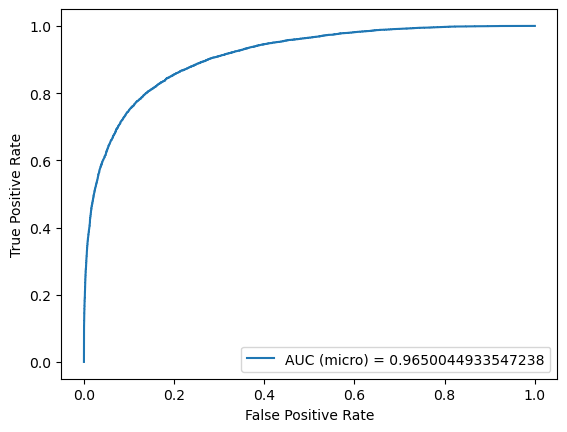

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(preds["y_true"].flatten(), preds["logits"].flatten())

plt.plot(fpr, tpr, label="AUC (micro) = 0.9650044933547238")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend(loc=4)

In [ ]:
from sklearn.metrics import f1_score, jaccard_score

In [ ]:
model = make_model(hyperparams)
model.load_state_dict(torch.load("models/2023-11-22-18:43:46_checkpoint.pt"))
model.to(device)
_ = model.eval()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
dc = DataClass(hyperparams, ["i can't wait"], pred_mode=True)
dl = DataLoader(dc, batch_size=100, shuffle=False)

Reading twitter_2018 - 1grams ...
Reading twitter_2018 - 2grams ...
Reading twitter_2018 - 1grams ...


PreProcessing dataset ...: 100%|██████████| 1/1 [00:00<00:00, 1421.32it/s]


In [ ]:
logits = model.predict(next(iter(dl)), device)[2].cpu().detach().numpy()
probs = 1/(1+np.exp(-logits))[0]

# label_names = ["admiration", "amusement", "anger", "annoyance", "approval", "caring", "confusion", "curiosity", "desire", "disappointment", "disapproval", "disgust", "embarrassment", "excitement", "fear", "gratitude", "grief", "joy", "love", "nervous", "optimism", "pride", "realization", "relief", "remorse", "sadness", "surprise", "neutral"]
label_names = ["anger", "anticipation", "disgust", "fear", "joy", "love", "optimism", "hopeless", "sadness", "surprise", "trust"]

for i in range(len(label_names)):
    print(f"{probs[i]:.3f}", label_names[i])

0.006 anger
0.441 anticipation
0.003 disgust
0.010 fear
0.017 joy
0.005 love
0.032 optimism
0.021 hopeless
0.011 sadness
0.056 surprise
0.269 trust


In [ ]:
label_names = ["admiration", "amusement", "anger", "annoyance", "approval", "caring", "confusion", "curiosity", "desire", "disappointment", "disapproval", "disgust", "embarrassment", "excitement", "fear", "gratitude", "grief", "joy", "love", "nervous", "optimism", "pride", "realization", "relief", "remorse", "sadness", "surprise", "neutral"]

y_true = pd.DataFrame(preds['y_true'], columns=label_names)
y_pred = pd.DataFrame(preds['y_pred'], columns=label_names)
logits = pd.DataFrame(preds['logits'], columns=label_names)

correlation = "pearson"

y_true_corr = y_true.corr(correlation)
y_pred_corr = y_pred.corr(correlation)
logits_corr = logits.corr(correlation)

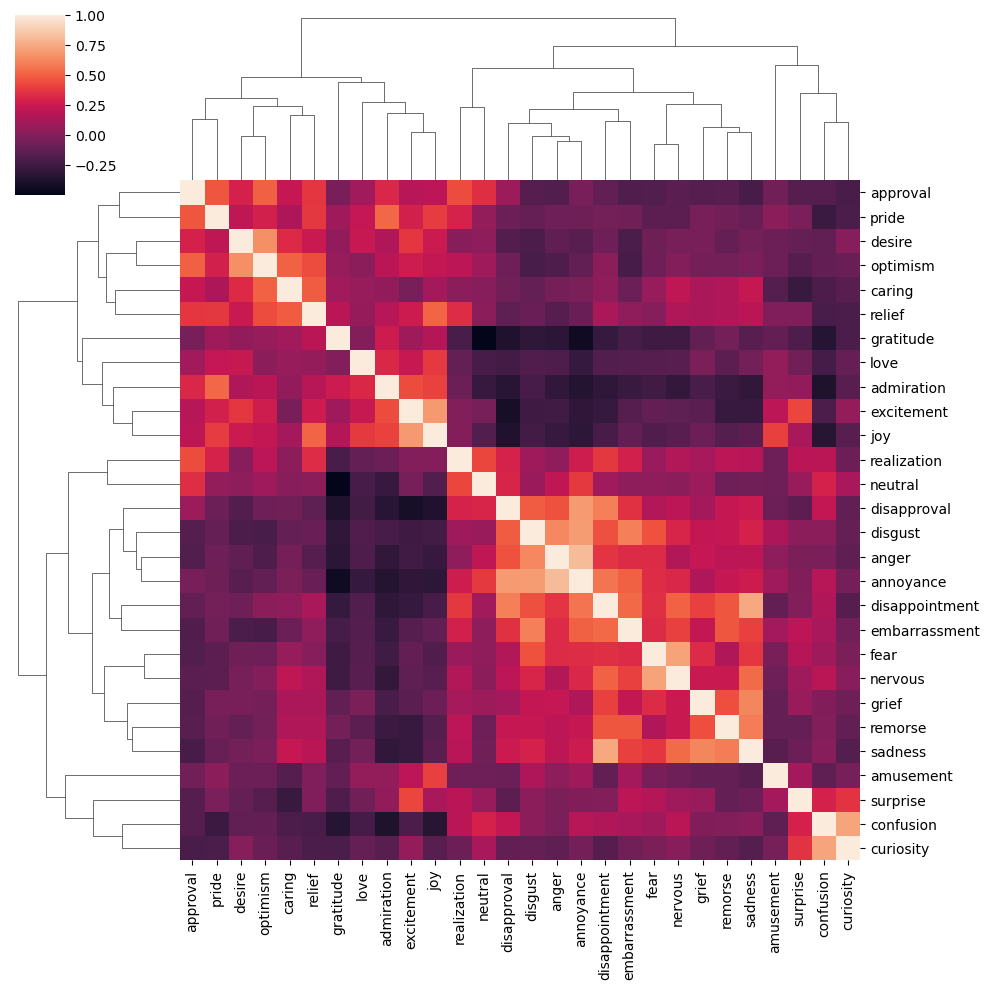

In [ ]:
_ = sns.clustermap(logits_corr, annot=False)

In [ ]:
# data = pd.read_csv("data/test.csv")

# wrongs = [(i[0], i[1].sum(), [(j, label_names[j]) for j, x in enumerate(i[1]) if x]) for i in enumerate(preds['y_true'] != preds['y_pred']) if i[1].any()]
# test_data = [(i, data['text'][i], [(j, label_names[j]) for j in range(28) if data[str(j)][i]]) for i in data.index]
# test_data = [test_data[i[0]] for i in wrongs]